## Local Setup

If you prefer to work locally, see the following instructions for setting up Python in a virtual environment.
You can then ignore the instructions in "Colab Setup".

If you haven't yet, create a [conda](https://docs.conda.io/projects/conda/en/latest/user-guide/install/index.html) environment using:
```
conda create --name rl_exercises
conda activate rl_exercises
```
Torch recommends installation using conda rather than pip, so run:
```
conda install pytorch cpuonly -c pytorch
```
If you have a CUDA-enabled GPU and would like to use it, visit [the installation page](https://pytorch.org/get-started/locally/) to see the options available for different CUDA versions.
The remaining dependencies can be installed with pip:
```
pip install matplotlib numpy tqdm ipykernel "gymnasium[toy-text]"
```

Even if you are running the Jupyter notebook locally, please run the code cells in **Colab Setup**, because they define some global variables required later.

## Colab Setup

Google Colab provides you with a temporary environment for python programming.
While this conveniently works on any platform and internally handles dependency issues and such, it also requires you to set up the environment from scratch every time.
The "Colab Setup" section below will be part of **every** exercise and contains utility that is needed before getting started.

There is a timeout of about ~12 hours with Colab while it is active (and less if you close your browser window).
Any changes you make to the Jupyter notebook itself should be saved to your Google Drive.
We also save all recordings and logs in it by default so that you won't lose your work in the event of an instance timeout.
However, you will need to re-mount your Google Drive and re-install packages with every new instance.

In [1]:
"""Your work will be stored in a folder called `rl_ws23` by default to prevent Colab 
instance timeouts from deleting your edits.
We do this by mounting your google drive on the virtual machine created in this colab 
session. For this, you will likely need to sign in to your Google account and allow
access to your Google Drive files.
"""

import os
from pathlib import Path
try:
    from google.colab import drive
    drive.mount("/content/gdrive")
    COLAB = True
except ImportError:
    COLAB = False

# Create paths in your google drive
if COLAB:
    DRIVE_PATH = "/content/gdrive/My\ Drive/rl_ws23"
    DRIVE_PYTHON_PATH = DRIVE_PATH.replace("\\", "")
    if not os.path.exists(DRIVE_PYTHON_PATH):
        %mkdir $DRIVE_PATH

    # the space in `My Drive` causes some issues,
    # make a symlink to avoid this
    DATA_ROOT = "/content/rl_ws23"
    if not os.path.exists(DATA_ROOT):
        !ln -s $DRIVE_PATH $DATA_ROOT
    %cd $DATA_ROOT

    DATA_ROOT = Path(DATA_ROOT)
else:
    DATA_ROOT = Path.cwd() / "rl_ws23"

# Install **python** packages
if COLAB:
    %pip install matplotlib numpy tqdm gymnasium[toy-text]

# Exercise 1

In this homework, we will implement basic planning and reinforcement learning algorithms.
We will look at Policy Iteration and Value Iteration, as well as tabular Q-Learning.
The algorithms will be evaluated on a gridworld task from OpenAI gym.

All homeworks are self-contained.
They can be completed in their respective notebooks.
To edit and re-run code, you can therefore simply edit and restart the code cells below.
When you are finished, you will need to submit the notebook as well as all saved figures (see exercises) as a zip file via Ilias.

We start by importing all the necessary python modules and defining some helper functions which you do not need to
change.
Still, make sure you are aware of what they do.
The code is split into the following sections:
 * Logging/Recording utility
 * Runtime arguments
 * Functional code (classes, functions, ...) and explanations

## Hint

We will be working with Gymnasium DiscreteEnvs. These environments have a property P which is a dictionary of lists, where
```
P[s][a] == [(transition probability, next state, reward, done), ...]
```
for a state $s$ and an action $a$. In FrozenLake, each action has a 33% chance of being executed correctly, and a 33%
chance for adjacent actions, respectively. In non-terminal states, len(P[s][a]) == 3.
This environment is very similar to the one shown in the Optimal Decision Making lecture.

In [2]:
import time

import matplotlib.pyplot as plt
import tqdm


class ProgressBar:
    def __init__(self, num_iterations: int, verbose: bool = True):
        if verbose:  # create a nice little progress bar
            self.scalar_tracker = tqdm.tqdm(
                total=num_iterations,
                desc="Scalars",
                bar_format="{desc}",
                position=0,
                leave=True,
            )
            progress_bar_format = (
                "{desc} {n_fmt:"
                + str(len(str(num_iterations)))
                + "}/{total_fmt}|{bar}|{elapsed}<{remaining}"
            )
            self.progress_bar = tqdm.tqdm(
                total=num_iterations,
                desc="Iteration",
                bar_format=progress_bar_format,
                position=1,
                leave=True,
            )
            self.verbose = True
        else:
            self.verbose = False

    def __call__(self, **kwargs):
        if self.verbose:
            formatted_scalars = {
                key: "{:.3e}".format(value[-1] if isinstance(value, list) else value)
                for key, value in kwargs.items()
            }
            description = "Scalars: " + ", ".join(
                [f"{key}={value}" for key, value in formatted_scalars.items()]
            )
            self.scalar_tracker.set_description(description)
            self.progress_bar.update(1)


# specify the path to save the recordings of this run to.
DATA_PATH = DATA_ROOT / "exercise_1" / time.strftime("%Y-%m-%d_%H-%M")

# this function will automatically save the current figure into your google drive folder or local directory
def save_figure(save_name: str) -> None:
    DATA_PATH.mkdir(parents=True, exist_ok=True)
    path = DATA_PATH / (save_name + ".png")
    plt.savefig(str(path))

In [3]:
import numpy as np
import gymnasium as gym  # gymnasium is successor to gym
from gymnasium.envs.toy_text.frozen_lake import FrozenLakeEnv
from IPython import display


# Hyperparameters
gamma = 0.99  # discount factor
alpha = 0.1  # learning rate
t_decay = 10000  # rate at which greedy actions are preferred over random ones
SEED = 1

np.random.seed(SEED)


def measure_policy_success(
    env: FrozenLakeEnv,
    pi: np.ndarray,
    n_eval: int,
    render: bool = False,
) -> float:
    """Evaluate a policy on an environment and return success rate

    :param env: FrozenLake env
    :param pi: a policy represented by action probabilities for each action in each state
    :param render: Render the policy
    :return: The mean success rate of the given policy
    """

    successes = []
    env.reset()
    window = plt.imshow(env.render())

    for _ in range(n_eval):
        state, info = env.reset()
        if render:
            window.set_data(env.render())
        for _ in range(100):
            action = int(pi[state])

            state, reward, terminated, truncated, info = env.step(action)

            if render:
                window.set_data(env.render())
                display.display(plt.gcf())
                display.clear_output(wait=True)

            if terminated or truncated:
                successes.append(reward)
                break

    return np.mean(successes)


def plot_learning_curve(success_rates: list[float]) -> None:
    """Plot the learning curve"""
    _, ax = plt.subplots()
    ax.plot(success_rates)
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Success Rate")


def plot_value_function(value_function: np.ndarray, env: FrozenLakeEnv) -> None:
    """Plot the value function for a given environment.

    :param vf: A value function
    :param env: An environment
    :return:
    """
    shape = (env.unwrapped.nrow, env.unwrapped.ncol)

    fig, ax = plt.subplots()
    im = ax.imshow(value_function.reshape(shape))

    for i in range(shape[0]):
        for j in range(shape[1]):
            text = ax.text(
                j,
                i,
                env.unwrapped.desc[i, j].decode(),
                ha="center",
                va="center",
                color="w",
            )

## The FrozenLake Environment
First, let's have a look at the problem we are solving. The agent controls the movement of a character in a grid world.
Some tiles of the grid are walkable, and others lead to the agent falling into the water.
Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction.
The agent is rewarded for finding a walkable path to a goal tile.
The episode ends when you reach the goal or fall in a hole.
You receive a reward of 1 if you reach the goal, and zero otherwise.
Actions are encoded as integers 0 = left, 1 = down, 2 = right and 3 = up.
The states are counted from 0 to $N_{states}$.

![The FrozenLake Environment](https://gymnasium.farama.org/_images/frozen_lake.gif)

See https://gymnasium.farama.org/environments/toy_text/frozen_lake/

Execute the next cell to see what a randomly initialized policy does.

Note: the dynamics of the environment are available to you through the `mdp` variable.
If you index this with the state and the action (i.e. `mdp[state][action]`), you are given a list of possible transitions, where each transition is a tuple of the form `(transition_prob: float, next_state: int, reward: float, done: bool)`.
In other words, each transition has an associated probability, reward, and next state.
Because the reward depends on the next state and not just the action (i.e. $r=r(s,a,s')$), we must slightly update the equations for policy iteration and value iteration seen in the lecture.

Random policy success rate=0.0


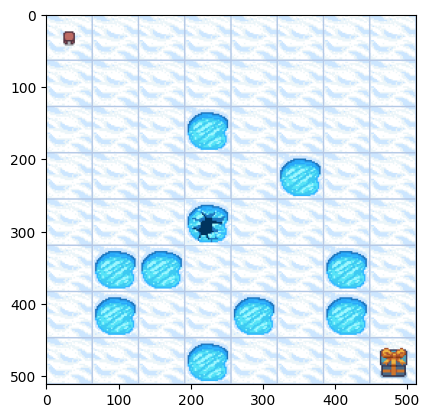

In [4]:
env: FrozenLakeEnv = gym.make("FrozenLake-v1", map_name="8x8", render_mode="rgb_array")
env.reset(seed=SEED)

n_actions = env.action_space.n
n_states = env.observation_space.n
pi_random = np.random.choice(n_actions, n_states)

success_rate = measure_policy_success(env, pi_random, n_eval=1, render=True)

print(f"Random policy success rate={success_rate}")

## **TASK 1: Policy Iteration**
The first algorithm we will implement is called Policy Iteration.
It consists of an inner and an outer loop.
The inner loop is called Policy Evaluation and evaluates a given policy on a problem.
For every state, it returns the exact value, i.e. the expected return under the current policy.
The outer loop is called Policy Improvement and, as the name suggests, takes the current policy's value function
and returns an improved version.
In Policy Iteration, we first initialize a policy and value function randomly, and then iteratively run Policy
Evaluation and Policy Improvement until convergence.

The **pseudocode** looks as follows:

---
- **Init** Initialize $V_{(0)}^{\pi_0}(s)=0$ for all $s$, $\pi_0 \leftarrow$ uniform, $k = 0$

- **Repeat**  For $i=1, 2, \dots$

    - `Policy Evaluation`

        - **Init** Initialize $V_{(0)}^{\pi_{i}}(s) = V_{(k)}^{\pi_{i-1}}(s)$ (i.e. initialize the value function of the new policy with the converged value function of the old policy)

        - **Repeat** For $k=1, 2, \dots$

            \begin{equation*}
                V_{(k)}^{\pi_{i}}(s) = \sum_a \pi(a \mid s) \sum_{s'} P(s' \mid s,a) \Big( r(s,a,s') + \gamma \, V_{(k - 1)}^{\pi_{i}}(s') \Big)
            \end{equation*}

        - **Until convergence**

    - `Policy Improvement`

        \begin{align*}
            \pi_{(i+1)}(a \mid s) = \begin{cases}
                1, & \text{if } a =  \underset{a'}{\arg \max} \sum_{s'} P(s' \mid s,a') \Big( r(s,a',s') + \gamma \, V^{\pi_i}(s') \Big)\\
                0 & \text{else}
            \end{cases}
        \end{align*}

- **Until convergence**

---

### Task 1.1 (4 Points)
In this first task you have to implement the missing code snippets (marked as *TODO*) of the policy iteration class. The **pseudocode** shown above might be helpful. 
1. Implement the missing code snippet of the **policy_evaluation** function below. (2 points)
2. Implement the missing code snippet of the **policy_improvement** function below. (2 points)

After you have finished implementing the corresponding functions, execute the code cell *Run Policy Iteration*. This code cell will automatically save your value function plot and the learning curve plot, either into your mounted drive folder or in a subdirectory on your local disk. You will need to submit these figures together with the notebook as a zip file.  

iter   | max|V-Vprev| | #actions chg | V[0]  
-------+--------------+--------------+-------
   0   |      0.38395 |     43       |   0.001
   1   |      0.61500 |      6       |   0.378
   2   |      0.04048 |      0       |   0.415
   3   |      0.00000 |      0       |   0.415
   4   |      0.00000 |      0       |   0.415
   5   |      0.00000 |      0       |   0.415
   6   |      0.00000 |      0       |   0.415
   7   |      0.00000 |      0       |   0.415
   8   |      0.00000 |      0       |   0.415
   9   |      0.00000 |      0       |   0.415


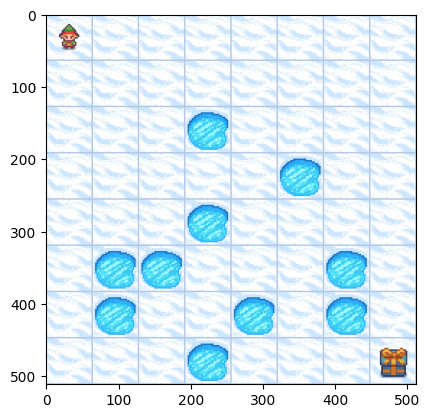

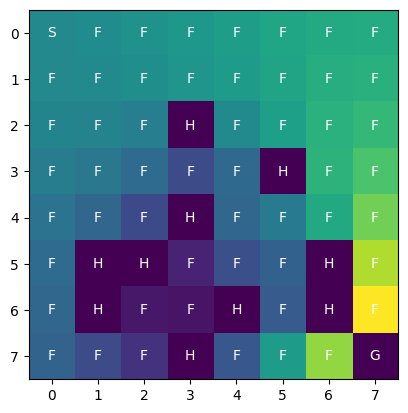

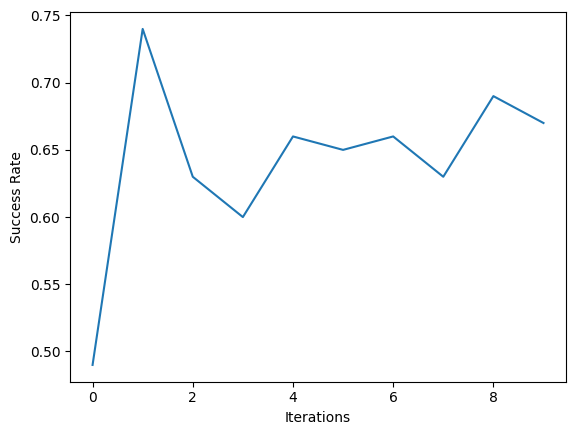

In [5]:
class PolicyIteration:
    def __init__(
        self,
        gamma: float,
        n_iters: int,
        policy_eval_iters: int = 10000,
    ) -> None:
        """A class for performing Policy Iteration

        :param env:
        :param gamma:
        """
        self.gamma = gamma
        self.n_iters = n_iters
        self.policy_eval_iters = policy_eval_iters

    def policy_evaluation(
        self,
        mdp: dict[int, dict[int, list[tuple[float, int, float, bool]]]],
        pi_prob: np.ndarray,
        previous_value: np.ndarray,
    ) -> np.ndarray:
        """Perform the Policy Evaluation step given a policy pi and an environment.

        :param mdp: an MDP as a list of transitions for each state-action pair
        :param pi_prob: Action probabilities [num_states, num_actions]
        :param previous_value: Initial value function
        :return: value function of the provided policy [num_states]
        """
        n_states, n_actions = pi_prob.shape
        value = np.copy(previous_value)
        for _ in range(self.policy_eval_iters):
            ## SOLUTION ##
            for state in range(n_states):
                # clear the value estimate for this state
                value[state] = 0
                for action in range(n_actions):
                    # transitions is a list of tuple representing each possible outcome of this
                    # action in this state
                    transitions = mdp[state][action]
                    # compute expected return from taking this action in this state, where the
                    # expectation is over the various possible transitions
                    q_s_a = sum(
                        transition_prob
                        * (reward + self.gamma * previous_value[next_state])
                        for transition_prob, next_state, reward, done in transitions
                    )
                    # accumulate value of this state resulting from this action and the
                    # probability of the policy choosing it
                    value[state] += pi_prob[state, action] * q_s_a

            # run policy evaluation until convergence
            if np.allclose(value, previous_value):
                break

            # save current value estimate for next iteration
            previous_value[...] = value

        return value

    def policy_improvement(
        self,
        mdp: dict[int, dict[int, list[tuple[float, int, float, bool]]]],
        value: np.ndarray,
    ) -> tuple[np.ndarray, np.ndarray]:
        """Perform the Policy Improvement step given a value function.

        :param mdp: an MDP as a list of transitions for each state-action pair
        :param value: Value function of a policy [num_states]
        :return: New policy [num_states] and distribution over action probabilities [num_states, num_actions]
        """
        n_states, n_actions = len(mdp), len(mdp[0])
        # initialize policy
        # contains the actual actions
        pi = np.zeros(shape=n_states, dtype=np.int64)
        # contains the action probabilities for each state
        pi_prob = np.zeros(shape=(n_states, n_actions))

        ## SOLUTION ##
        for state in range(n_states):
            # list of q values for current state s
            qs = []
            for action in range(n_actions):
                # transitions is a list of tuple representing each possible outcome of this
                # action in this state
                transitions = mdp[state][action]
                # compute expected return from taking this action in this state, where the
                # expectation is over the various possible transitions
                q_s_a = sum(
                    transition_prob * (reward + self.gamma * value[next_state])
                    for transition_prob, next_state, reward, done in transitions
                )
                qs.append(q_s_a)

            # new policy action is the one with highest q
            pi[state] = np.argmax(qs)
            # set probability of best action to 1.0, all others 0.0
            pi_prob[state, pi[state]] = 1

        return pi, pi_prob

    def __call__(
        self,
        env: FrozenLakeEnv,
    ) -> tuple[np.ndarray, np.ndarray, list[float]]:
        """Perform Policy Iteration given a DiscreteEnv environment and a discount factor gamma for n_iter iterations

        :param env: An openAI Gym DiscreteEnv object
        :param gamma: Discount factor
        :param n_iter: Number of PI iterations
        :return: Final value function [num_states] and optimal policy [num_states]

        """

        n_states = env.observation_space.n
        n_actions = env.action_space.n
        mdp = env.unwrapped.P
        value = np.zeros(shape=n_states)
        pi = np.zeros(shape=n_states, dtype=np.int64)  # contains the actual actions
        pi_prob = (
            np.ones(shape=(n_states, n_actions)) / n_actions
        )  # contains the action probabilities for each state

        print("iter   | max|V-Vprev| | #actions chg | V[0]  ")
        print("-------+--------------+--------------+-------")
        success_rates = []
        for iter in range(self.n_iters):
            previous_pi = np.copy(pi)
            previous_value = np.copy(value)

            # run policy evaluation
            value = self.policy_evaluation(mdp, pi_prob, value)

            # run policy improvement
            pi, pi_prob = self.policy_improvement(mdp, value)

            # evaluate policy success rate
            success_rate = measure_policy_success(env, pi, n_eval=100)
            success_rates.append(success_rate)

            max_diff = np.abs(value - previous_value).max()
            n_chg_actions = (pi != previous_pi).sum()

            print(
                f"{iter:4d}   | {max_diff:12.5f} |   {n_chg_actions:4d}       | {value[0]:7.3f}"
            )

        return value, pi, success_rates


# Run Policy Iteration
policy_iteration = PolicyIteration(
    gamma,
    n_iters=10,
)
value, pi, success_rates = policy_iteration(env)

plot_value_function(value, env)
save_figure("vf_pi")
plot_learning_curve(success_rates)
save_figure("lc_pi")

## **TASK 2: Value Iteration**
Next, we will have a look at Value Iteration.
It is very similar to Policy Iteration and only executes one step of policy evaluation.
The **pseudocode** looks as follows

---
- **Init** Initialize $V_{(0)}^\ast(s)=0$, for all $s$

- **Repeat**  For $i=1, 2, \dots$

    \begin{equation*}
        V^\ast_{(i)}(s) = \underset{a}{\max} \sum_{s'} P(s' \mid s,a) \Big( r(s,a,s') + \gamma \, V^\ast_{(i-1)}(s') \Big)
    \end{equation*}

- **Until convergence**

---


### Task 2.1 (4 Points)
In this task you have to implement the missing code snippets (marked as *TODO*) of the Value iteration calss. The **psuedocode** shown above might be helpful.
1. Implement the missing code snippet of the **value_iteration** function below 

After you have finished implementing the corresponding functions, execute the code cell *Run Value Iteration*. This code cell will automatically save your value function plot and the learning curve plot, either into your mounted drive folder or in a subdirectory on your local disk. You will need to submit these figures together with the notebook as a zip file. 

iter   | max|V-Vprev| | #actions chg | V[0]  
-------+--------------+--------------+-------


/home/balazs/repos/alr/RL-Notebooks/.env/lib/python3.11/site-packages/gymnasium/envs/toy_text/frozen_lake.py:328: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("FrozenLake-v1", render_mode="rgb_array")
  gym.logger.warn(


TypeError: Image data of dtype object cannot be converted to float

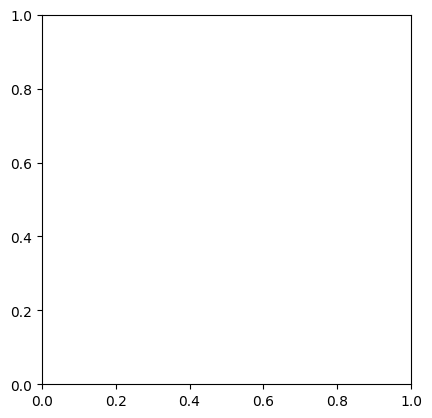

In [6]:
class ValueIteration:
    def __init__(self, gamma: float, n_iters: int) -> None:
        """A class for performing Value Iteration

        :param env: A FrozenLakeEnv environment
        :param gamma: Discount factor
        """
        self.gamma = gamma
        self.n_iters = n_iters

    def __call__(
        self,
        env: FrozenLakeEnv,
    ) -> tuple[np.ndarray, np.ndarray, list[float]]:
        """Perform Value Iteration given a DiscreteEnv environment and a discount factor gamma for n_iter iterations.

        :param n_iter: Number of VI iterations
        :return: A tuple (final value_function [num_states], optimal policy [num_states])
        """

        n_states = env.observation_space.n
        n_actions = env.action_space.n
        mdp = env.unwrapped.P
        value = np.zeros(shape=n_states)
        pi = np.zeros(shape=n_states, dtype=np.int64)  # contains the actual actions

        print("iter   | max|V-Vprev| | #actions chg | V[0]  ")
        print("-------+--------------+--------------+-------")
        success_rates = []
        for iter in range(0, self.n_iters):
            previous_pi = np.copy(pi)
            previous_value = np.copy(value)

            ## SOLUTION ##
            for state in range(n_states):  # loop over all states
                qs = []  # list for q values in current state
                for action in range(n_actions):
                    transition = mdp[state][action]
                    q_s_a = sum(
                        transition_prob
                        * (reward + self.gamma * previous_value[next_state])
                        for transition_prob, next_state, reward, done in transition
                    )
                    qs.append(q_s_a)

                # optimal action is the one with the highest q
                pi[state] = np.argmax(qs)
                # value of state is the q of the best action
                value[state] = np.max(qs)

            # Evaluate policy success rate
            success_rate = measure_policy_success(env, pi, n_eval=100)
            success_rates.append(success_rate)

            max_diff = np.abs(value - previous_value).max()
            n_chg_actions = (pi != previous_pi).sum()

            print(
                f"{iter:4d}   | {max_diff:12.5f} |   {n_chg_actions:4d}       | {value[0]:7.3f}"
            )

        return value, pi, success_rates


# Run Value Iteration
value_iteration = ValueIteration(gamma, n_iters=100)
value, pi, success_rates = value_iteration(env)

plot_value_function(value, env)
save_figure("vf_vi")
plot_learning_curve(success_rates)
save_figure("lc_vi")

## **TASK 3: Q-Learning**
In Policy Iteration and Value Iteration, we assume to have knowledge about the problem's underlying dynamics and reward
function. These properties are usually not available in practice.
Instead, we need to solve the problem by exploiting what we have learned so far and exploring previously unseen situations.
An algorithm to solve a problem in this fashion is Q-Learning. The **pseudocode** is given as

---
- **Init** Initialize $Q_{(0)}(s, a)=0$, for all $s$ and $a$

- **Repeat**  For $i=1, 2, \dots$
    - sample an action $a$ using the exploration strategy and get the next state $s'$ and associated reward $r$
    - If s' is terminal:
        - $\delta = r(s, a) - Q_{(i-1)}(s, a)$
        - Reset environment and sample new initial state $ s' $
    - Else:
        - $\delta = r(s, a) + \gamma \underset{a'}{\max} Q_{(i-1)}(s', a') - Q_{(i-1)}(s, a)$

    $Q_{(i)}(s, a) = Q_{(i-1)}(s, a) + \alpha \delta$ 
    
    Set $ s \leftarrow s' $

- **Until convergence**

---

### Task 3.1 (4 Points)
We will implement the missing cod snippet (marked as *TODO*) of the QLearning class. The **pseudoclass** shown above might be helpful.

1. Finish the Q-Learning inner loop in the learn function, by implementing the TD-Error and the Q-Learning update rule 

After you have finished implementing the corresponding functions, execute the code cell *Run QLearning*. This code cell will automatically save your value function plot and the learning curve plot, either into your mounted drive folder or in a subdirectory on your local disk. You will need to submit these figures together with the notebook as a zip file. 

In [ ]:
class QLearning:
    def __init__(
        self,
        gamma: float,
        alpha: float,
        t_decay: float,
        n_iters: int,
    ) -> None:
        """A class for tabular Q-Learning with epsilon-greedy exploration.
         The policy is defined implicitly by the Q-function attribute.

        :param env: A FrozenLakeEnv environment
        :param gamma: Discount factor
        :param alpha: Learning rate
        """
        self.gamma = gamma
        self.alpha = alpha
        self.t_decay = t_decay
        self.n_iters = n_iters

    def sample_action(self, q: np.ndarray, state: int, t: int) -> int:
        """Sample an action based given the state id on the epsilon greedy strategy with time decaying exploration.

        :param s: A state id represented as an integer over all state ids.
        :return: An action id, corresponding to the available actions described above.
        """

        if np.random.random() < min(0.99, t / self.t_decay):
            # return the greedy action, i.e. the one with the highest q
            action = int(np.argmax(q[state]))
        else:
            # return a random action
            action = np.random.randint(0, len(q[state]))

        return action

    def __call__(
        self,
        env: FrozenLakeEnv,
    ) -> tuple[np.ndarray, np.ndarray, list[float]]:
        """Perform n_iter iterations of Q-Learning

        :param n_iter: Number of learning iterations
        :return: The learned Value function and policy as a tuple (final value_function [num_states], optimal policy [num_states])
        """
        n_states = env.observation_space.n
        n_actions = env.action_space.n
        q = np.zeros((n_states, n_actions))

        state, info = env.reset()

        success_rates = []
        for t in range(self.n_iters):
            ## SOLUTION ##
            action = self.sample_action(q, state, t)

            next_state, reward, terminated, truncated, info = env.step(action)

            ## SOLUTION ##
            delta = reward - q[state, action]
            if not terminated:
                delta += self.gamma * np.max(q[next_state])
            q[state, action] = q[state, action] + self.alpha * delta

            if terminated or truncated:
                state, info = env.reset()
            else:
                state = next_state

            # evaluate policy success rate
            if t % 100 == 0:
                success_rate = measure_policy_success(env, np.argmax(q, axis=1), n_eval=100)
                success_rates.append(success_rate)

        value = np.max(q, axis=1)
        pi = np.argmax(q, axis=1)

        return value, pi, success_rates


# Run QLearning
small_env: FrozenLakeEnv = gym.make("FrozenLake-v1", map_name="4x4", render_mode="rgb_array")
small_env.reset(seed=SEED)

q_learning = QLearning(gamma, alpha, t_decay, n_iters=20000)
value, pi, success_rates = q_learning(small_env)

plot_value_function(value, small_env)
save_figure("vf_q")
plot_learning_curve(success_rates)
save_figure("lc_q")

### Task 3.2 (3 Points)
You may have noticed that we used the 4x4 version of the environment for the Q-Learning algorithm instead of the 8x8 one. You will find that the 8x8 version does not learn anything. Find out why this is the case and propose a solution for it. Give a short and precise summary of what you would do in 3-5 sentences (3 Points).

.## SOLUTION ##

The agent is very unlikely to find the goal by random exploration at the beginning of training.
Because it doesn't have access to the MDP, it is never aware of the reward for reaching the goal.
Without this, all Q values for all states are 0, and the agent never learns anything.

To overcome this, we need to use "dense rewards" to entice the agent to explore in the direction we want it to.




In [ ]:
# Run QLearning on the 8x8 environment
value, pi, success_rates = q_learning(env)

plot_value_function(value, env)
save_figure("vf_q_8x8")
plot_learning_curve(success_rates)
save_figure("lc_q_8x8")